In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Generate dates - hourly data
dates = pd.date_range(start='2018-01-01', periods=50000, freq='H')

# Seasonality in sales (simulate weekends and holidays spike)
day_of_week = dates.dayofweek
is_weekend = (day_of_week >= 5).astype(int)

# Base sales
base_sales = 8000 + 500 * np.sin(np.linspace(0, 50 * np.pi, 50000))

# Add boost for weekends
weekend_boost = is_weekend * np.random.normal(3000, 500, size=50000)

# Add trend
trend = np.linspace(0, 3000, 50000)

# Historical sales = base + weekend + trend + noise
historical_sales = base_sales + weekend_boost + trend + np.random.normal(0, 500, size=50000)

sales_data = pd.DataFrame({
    'Date': dates,
    'Customer_ID': np.random.randint(1000, 4000, size=50000),
    'Historical_Sales': np.clip(historical_sales, 1000, None),
    'Customer_Trends_Score': np.clip(0.6 + 0.1 * np.sin(np.linspace(0, 20*np.pi, 50000)) + np.random.normal(0, 0.05, 50000), 0, 1),
    'Sales_Channel': np.random.choice(['Wholesale', 'Online', 'Retail'], size=50000, p=[0.4, 0.4, 0.2])
})

# Revenue depends on Sales and Customer Trend
sales_data['Revenue'] = sales_data['Historical_Sales'] * (2.0 + 0.5 * sales_data['Customer_Trends_Score'])

sales_data.to_csv('sales_data123.csv', index=False)
print("✅ Smart Sales data generated:", sales_data.shape)

✅ Smart Sales data generated: (50000, 6)


In [2]:
# Inventory dates
inventory_dates = pd.date_range(start='2018-01-01', periods=50000, freq='H')

# Demand trend cyclic pattern
demand_trend_signal = np.sin(np.linspace(0, 20 * np.pi, 50000))

# Stock level based on demand trend
stock_level = 500 + 100*demand_trend_signal + np.random.normal(0, 30, 50000)

# Risk increases when stock is low
risk_score = np.clip(1 - (stock_level / (stock_level.max() + 10)) + np.random.normal(0, 0.05, 50000), 0, 1)

inventory_data = pd.DataFrame({
    'Date': inventory_dates,
    'Product_ID': np.random.randint(2000, 2100, size=50000),
    'Stock_Level': np.clip(stock_level, 0, None),
    'Reorder_Cycle_Days': np.random.choice([7, 15, 30], size=50000, p=[0.3, 0.5, 0.2]),
    'Demand_Trend': np.where(demand_trend_signal > 0.2, 'Rising', np.where(demand_trend_signal < -0.2, 'Falling', 'Stable')),
    'Stockout_Risk_Score': risk_score
})

inventory_data.to_csv('inventory_data123.csv', index=False)
print("✅ Smart Inventory data generated:", inventory_data.shape)


✅ Smart Inventory data generated: (50000, 6)


In [4]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
assert len(tf.config.list_physical_devices('GPU')) > 0, "🚨 No GPU detected!"


Num GPUs Available:  1


In [5]:
model.save('lstm_sales_forecasting_model.h5')

In [6]:
from tensorflow.keras.models import load_model


In [7]:
model_loaded = load_model('lstm_sales_forecasting_model.h5')
print("Model successfully loaded ✅")

Model successfully loaded ✅


In [8]:
y_pred_loaded = model_loaded.predict(X_test)

235/235 [==============================] - 2s 6ms/step


In [9]:
y_pred_loaded_rescaled = scaler.inverse_transform(
    np.concatenate([y_pred_loaded, np.zeros((y_pred_loaded.shape[0], len(features)-1))], axis=1)
)[:, 0]


Epoch 1/20
625/625 - 11s - loss: 0.0153 - mae: 0.1024 - val_loss: 0.0151 - val_mae: 0.1143 - 11s/epoch - 17ms/step
Epoch 2/20
625/625 - 7s - loss: 0.0121 - mae: 0.0962 - val_loss: 0.0216 - val_mae: 0.1175 - 7s/epoch - 11ms/step
Epoch 3/20
625/625 - 6s - loss: 0.0115 - mae: 0.0949 - val_loss: 0.0186 - val_mae: 0.1109 - 6s/epoch - 10ms/step
Epoch 4/20
625/625 - 6s - loss: 0.0112 - mae: 0.0943 - val_loss: 0.0173 - val_mae: 0.1086 - 6s/epoch - 9ms/step
Epoch 5/20
625/625 - 6s - loss: 0.0111 - mae: 0.0941 - val_loss: 0.0167 - val_mae: 0.1082 - 6s/epoch - 9ms/step
Epoch 6/20
625/625 - 6s - loss: 0.0109 - mae: 0.0938 - val_loss: 0.0184 - val_mae: 0.1104 - 6s/epoch - 10ms/step
✅ Model saved as ls.h5
313/313 [==============================] - 2s 4ms/step
✅ R² Score: 0.0855


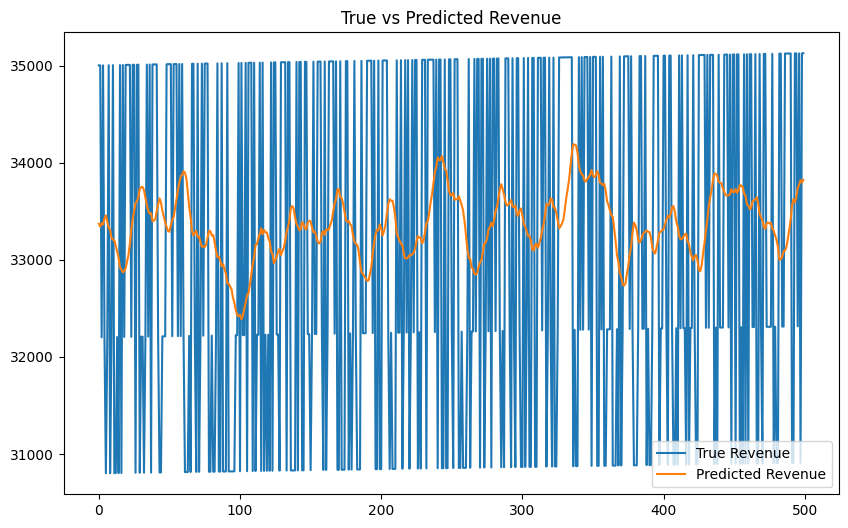

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load the sales data
sales_data = pd.read_csv('s.csv')
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
sales_data = sales_data.sort_values('Date')

# Encode 'Sales_Channel'
encoder = LabelEncoder()
sales_data['Sales_Channel'] = encoder.fit_transform(sales_data['Sales_Channel'])
joblib.dump(encoder, './models/le.pkl')  # Save encoder

# Select features and scale them
feature_cols = ['Historical_Sales', 'Customer_Trends_Score', 'Revenue', 'Sales_Channel']
scaler = MinMaxScaler()
sales_data_scaled = scaler.fit_transform(sales_data[feature_cols])
joblib.dump(scaler, './models/sc.pkl')  # Save scaler

# Create sequences from all features and predict Revenue (3rd column, index 2)
SEQ_LEN = 24
def create_sequences(data, target_index, seq_length=24):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(data[i][target_index])  # Predict Revenue
    return np.array(x), np.array(y)

X, y = create_sequences(sales_data_scaled, target_index=2, seq_length=SEQ_LEN)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, len(feature_cols))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Save the trained model
model.save('./models/ls.h5')
print("✅ Model saved as ls.h5")

# Evaluate predictions
y_pred = model.predict(X_test)

# To inverse transform only Revenue (index=2), we pad zeros for other features
y_pred_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((y_pred.shape[0], 2)), y_pred, np.zeros((y_pred.shape[0], 1))], axis=1))[:, 2]
y_test_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], 2)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))], axis=1))[:, 2]

# Score and plot
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"✅ R² Score: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:500], label='True Revenue')
plt.plot(y_pred_rescaled[:500], label='Predicted Revenue')
plt.legend()
plt.title("True vs Predicted Revenue")
plt.show()


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load the pre-trained model and scaler
try:
    model = tf.keras.models.load_model('./models/ls.h5')  # Load the trained LSTM model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'], run_eagerly=True)  # Ensure it's compiled for debugging
    print("Model loaded and compiled successfully.")
except Exception as e:
    print(f"Error loading the model: {e}")

# Load the scaler and label encoder
try:
    encoder = joblib.load('./models/le.pkl')  # Load the trained encoder
    scaler = joblib.load('./models/sc.pkl')  # Load the scaler
    print("Scaler and encoder loaded successfully.")
except Exception as e:
    print(f"Error loading scaler and encoder: {e}")

# Function to preprocess custom data for predictions
def preprocess_custom_data(new_data, seq_length=24):
    try:
        # Ensure 'Sales_Channel' is encoded the same way as the training data
        new_data['Sales_Channel'] = encoder.transform(new_data['Sales_Channel'])

        features = ['Historical_Sales', 'Customer_Trends_Score', 'Revenue', 'Sales_Channel']
        processed_data = new_data[features]

        # Scale the features (ensure we keep DataFrame structure to avoid warnings)
        processed_data_scaled = scaler.transform(processed_data)

        # Create sequences for LSTM input (same as during training)
        x = []
        if len(processed_data_scaled) >= seq_length:  # Ensure there are enough rows for sequences
            for i in range(seq_length, len(processed_data_scaled)):
                x.append(processed_data_scaled[i-seq_length:i])
        else:
            print(f"Error: Not enough data points. Minimum required: {seq_length}, Available: {len(processed_data_scaled)}")
            return None

        x = np.array(x)

        # Check the shape of the input data for debugging
        print(f"Input data shape: {x.shape}")

        return x
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        return None

# Function to predict revenue using the pre-trained LSTM model
def predict_revenue(new_data):
    try:
        X_new = preprocess_custom_data(new_data)
        if X_new is None:
            print("Error: Data preprocessing failed.")
            return None

        # Check if the shape of the data is valid
        if X_new.shape[0] == 0:
            print("Error: No data points available after preprocessing.")
            return None

        predictions = model.predict(X_new)
        if predictions is None:
            print("Error: Model prediction failed.")
            return None

        # Rescale predictions back to the original scale (only 'Revenue' column)
        predictions_rescaled = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 3))], axis=1))[:, 2]
        return predictions_rescaled
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Example: Custom data for testing (Ensure it's large enough to create sequences)
custom_data = pd.DataFrame({
    'Customer_ID': [1234] * 30,  # Increased rows to ensure sequences can be generated
    'Historical_Sales': np.random.randint(5000, 10000, 30),  # Random data for testing
    'Customer_Trends_Score': np.random.uniform(0.7, 1.1, 30),
    'Revenue': np.random.randint(10000, 30000, 30),
    'Sales_Channel': ['Wholesale'] * 30  # Assuming a single sales channel
})

# Predict revenue using the pre-trained model
predicted_revenue = predict_revenue(custom_data)

if predicted_revenue is not None:
    print("Predicted Revenue for the next period:")
    print(predicted_revenue)
else:
    print("Error: Could not generate predictions.")


Model loaded and compiled successfully.
Scaler and encoder loaded successfully.
Input data shape: (6, 24, 4)
1/1 [==============================] - 0s 50ms/step
Predicted Revenue for the next period:
[22000.66 22000.66 22000.66 22000.66 22000.66 22000.66]
